# Data exploration

Independent variables are

- `start_station_id`
- `weekday`
- `temperature_f`
- `precipitation_in`
- `windspeed_mph`
- `special_event`

These will be used to predict the ride `count`.

In [1]:
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    with open("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading config file')

In [3]:
data = pd.read_csv(config['data']['data_station_weather_clean'],
                  dtype={'start_station_id':str})

data['started_at_rounded'] = pd.to_datetime(data['started_at_rounded'], format="%Y-%m-%dT%H:%M:%S.%f")#.dt.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
data.head()

,started_at_rounded,weekday,start_station_id,count,start_station_name,start_lat,start_lng,temperature_f,precipitation_in,windspeed_mph
0,2021-07-01,4,4993.13,1,Old Slip & South St,40.703367,-74.007868,78.6,0.0,3.2
1,2021-07-01,4,5065.12,1,William St & Pine St,40.707179,-74.008873,78.6,0.0,3.2
2,2021-07-01,4,5114.06,1,West Thames St,40.708347,-74.017134,78.6,0.0,3.2
3,2021-07-01,4,5137.11,1,Fulton St & William St,40.709601,-74.006551,78.6,0.0,3.2
4,2021-07-01,4,5137.13,1,Spruce St & Gold St,40.710323,-74.004323,78.6,0.0,3.2


In [5]:
data.describe()

,started_at_rounded,weekday,count,start_lat,start_lng,temperature_f,precipitation_in,windspeed_mph
count,321129,321129.000000,321129.000000,321129.000000,321129.000000,321129.000000,321129.000000,321129.000000
mean,2022-07-15 18:57:52.223312384,3.959172,5.984894,40.708879,-74.010485,58.158136,0.003621,6.925111
min,2021-07-01 00:00:00,1.000000,1.000000,40.701221,-74.017134,2.700000,0.000000,0.000000
25%,2022-01-16 17:00:00,2.000000,2.000000,40.705693,-74.013133,44.800000,0.000000,4.500000
50%,2022-07-25 23:00:00,4.000000,4.000000,40.708533,-74.010202,59.400000,0.000000,6.400000
75%,2023-01-13 21:00:00,6.000000,8.000000,40.712455,-74.007868,71.600000,0.000000,8.900000
max,2023-06-30 23:00:00,7.000000,134.000000,40.715338,-74.001261,96.900000,0.429000,23.400000
std,NaN,1.964621,6.395749,0.004058,0.003844,16.500064,0.016655,3.417382


The `count` column has some interesting data - a station with 134 ride starts in an hour.

The features will need to be scaled to normalize the range.

## Outliers

Checking for outliers in the `count` column which contains the number of rides per hour from a station.

/Users/deborahhaar/Desktop/ironhack-work/citi_bikes/citi_venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


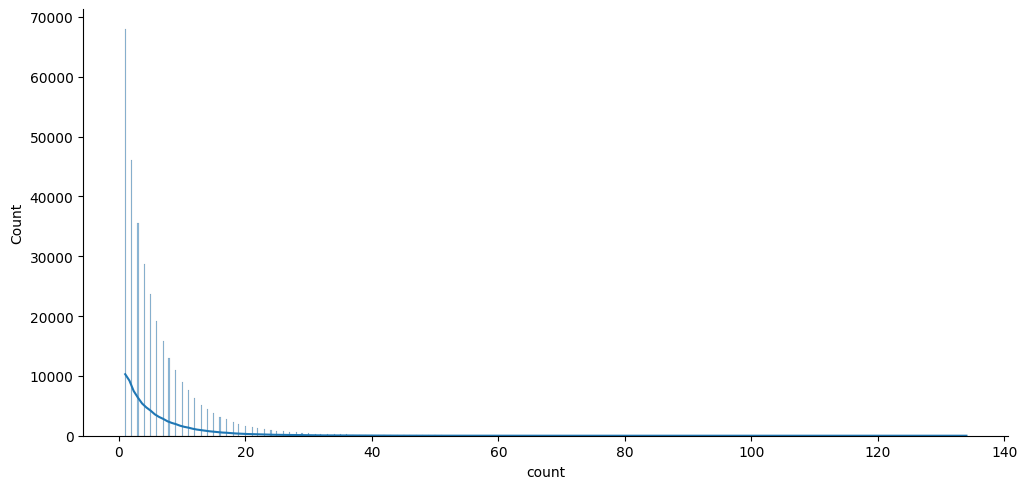

In [6]:
sns.displot(data=data, x='count', kde=True).fig.set_figwidth(12)
plt.show()

`count` is right skewed.

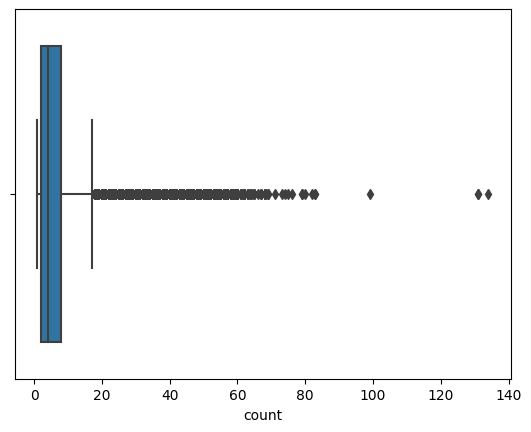

In [7]:
sns.boxplot(data=data, x='count')
plt.show()

In [8]:
#checking out the whiskers
iqr = np.percentile(data['count'],75) - np.percentile(data['count'],25)
upper_whisker = np.percentile(data['count'],75) + 1.5*iqr
lower_whisker = np.percentile(data['count'],25) - 1.5*iqr

print('upper whisker: {}'.format(upper_whisker))
print('lower whisker: {}'.format(lower_whisker))

upper whisker: 17.0
lower whisker: -7.0


In [9]:
data[data['count'] > 90]

,started_at_rounded,weekday,start_station_id,count,start_station_name,start_lat,start_lng,temperature_f,precipitation_in,windspeed_mph
166661,2022-08-06 12:00:00,6,5207.01,99,Centre St & Chambers St,40.712785,-74.004562,86.2,0.004,9.4
170245,2022-08-13 11:00:00,6,5207.01,134,Centre St & Chambers St,40.712785,-74.004562,74.6,0.000,7.2
173912,2022-08-20 11:00:00,6,5207.01,131,Centre St & Chambers St,40.712785,-74.004562,84.5,0.000,3.4
173938,2022-08-20 12:00:00,6,5207.01,131,Centre St & Chambers St,40.712785,-74.004562,86.0,0.000,4.9


After further investigation, the extreme outliers above are likely due to a special event that took place the Saturdays between August 6, 2022 and August 20, 2022, called [Summer Streets](https://www.nycgovparks.org/events/2022/08/20/summer-streets-2022). 

To deal with these outliers and the others, an additional column `special_events` will be added with a 1, non-outliers will be labled 0.

In [15]:
data['special_event'] = list(map(lambda x: 1 if x >17 else 0, data['count']))

### Check if log(count) fixes the distribution

## Weekdays

Does the day of the week matter to the count?

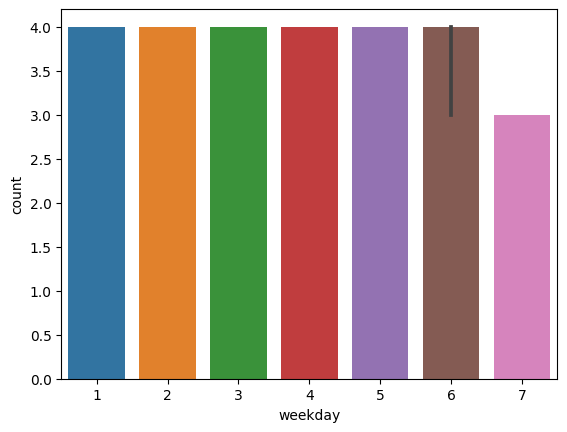

In [17]:
sns.barplot(data, x='weekday', y='count', estimator=np.median)
plt.show()

Considering just weekday vs weekend (rather than each day of the week)

In [18]:
data_weekday = data.copy()
data_weekday['weekday_binary'] = list(map(lambda x: 1 if x < 6 else 0, data['weekday']))

In [19]:
data_weekday.head()

,started_at_rounded,weekday,start_station_id,count,start_station_name,start_lat,start_lng,temperature_f,precipitation_in,windspeed_mph,special_event,weekday_binary
0,2021-07-01,4,4993.13,1,Old Slip & South St,40.703367,-74.007868,78.6,0.0,3.2,0,1
1,2021-07-01,4,5065.12,1,William St & Pine St,40.707179,-74.008873,78.6,0.0,3.2,0,1
2,2021-07-01,4,5114.06,1,West Thames St,40.708347,-74.017134,78.6,0.0,3.2,0,1
3,2021-07-01,4,5137.11,1,Fulton St & William St,40.709601,-74.006551,78.6,0.0,3.2,0,1
4,2021-07-01,4,5137.13,1,Spruce St & Gold St,40.710323,-74.004323,78.6,0.0,3.2,0,1


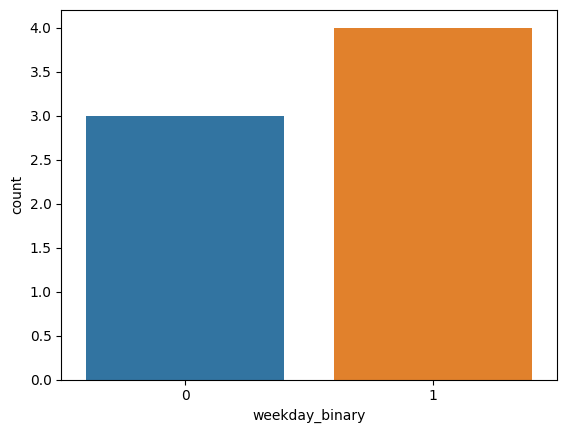

In [20]:
sns.barplot(data_weekday, x='weekday_binary', y='count', estimator=np.median)
plt.show()

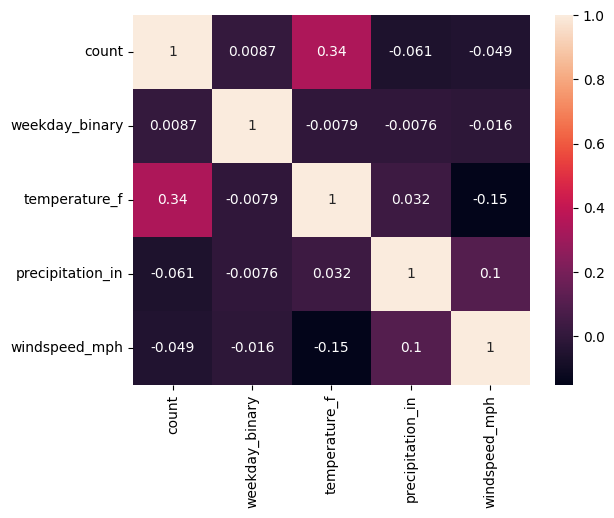

In [21]:
corr_matrix =  data_weekday[['count','weekday_binary','temperature_f','precipitation_in','windspeed_mph']].corr()
sns.heatmap(corr_matrix, annot=True) # annot = True displays the correlation values, annot=False hides the correlation values
plt.show()

There's no significant linear correlation between the features, so we will not do linear regression.

Both graphs below suggest that weekdays have higher ridership than weekends, but whether the granularity should be day of the week or just weekday or weekend is unclear. We will conduct a one-way ANOVA test and a two-sample TTest to check these assumptions.

### ANOVA test
Are the mean rental counts the same for each day of the week?

H-null: the mean ride count for each day of the week is the same

H-alt: at least one mean ride count for a day of the week is not the same

Significance lvel =0.05

In [24]:
import scipy.stats as st

In [25]:
anova_results = st.f_oneway(data[data['weekday'] == 1]['count'],
                            data[data['weekday'] == 2]['count'],
                            data[data['weekday'] == 3]['count'],
                            data[data['weekday'] == 4]['count'],
                            data[data['weekday'] == 5]['count'],
                            data[data['weekday'] == 6]['count'],
                            data[data['weekday'] == 7]['count'])
anova_results

F_onewayResult(statistic=45.005421800768524, pvalue=2.2556632017937163e-55)

The pvalue if less than 0.05, so we can reject the H-null. It is not the case that the means are the same for each day of the week.

In [32]:
anova_results2 = st.f_oneway(data[data['weekday'] == 1]['count'],
                            data[data['weekday'] == 2]['count'],
                            data[data['weekday'] == 3]['count'],
                            data[data['weekday'] == 4]['count'],
                            data[data['weekday'] == 5]['count'])
anova_results2

F_onewayResult(statistic=39.01289226606152, pvalue=1.0532861223034123e-32)

### Two sample T-Test (independent)

Are the mean rental counts the same for the weekdays and weekend?

H-null: the mean ride count is the same for weekdays and weekend

H-alt: the mean ride count is not the same for the weekdays and weekends

In [27]:
data_ttest = data_weekday[['weekday_binary', 'count']].copy()

In [30]:
data_ttest.head()

,weekday_binary,count
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [29]:
from scipy.stats import ttest_ind

In [33]:
#define samples
group1 = data_ttest[data_ttest['weekday_binary']== 1]
group2 = data_ttest[data_ttest['weekday_binary']== 0]

#perform independent two sample t-test
ttest_results = ttest_ind(group1['count'], group2['count'], alternative='two-sided')

ttest_results

TtestResult(statistic=4.955464076062335, pvalue=7.219445378437784e-07, df=321127.0)

The pvalue is less than 0.05, so we can reject the H-null. The mean ride count is not the same for weekdays and weekends.

The ANOVA looking at just weekdays (M-F) suggest that there are differences between the weekdays and the TTest indicated that there are differences between the means of the weekday and weekend groups. Therefore, we will encode all the days of the week, and not just use a binary split.

In [37]:
data.head()

,started_at_rounded,weekday,start_station_id,count,start_station_name,start_lat,start_lng,temperature_f,precipitation_in,windspeed_mph,special_event
0,2021-07-01,4,4993.13,1,Old Slip & South St,40.703367,-74.007868,78.6,0.0,3.2,0
1,2021-07-01,4,5065.12,1,William St & Pine St,40.707179,-74.008873,78.6,0.0,3.2,0
2,2021-07-01,4,5114.06,1,West Thames St,40.708347,-74.017134,78.6,0.0,3.2,0
3,2021-07-01,4,5137.11,1,Fulton St & William St,40.709601,-74.006551,78.6,0.0,3.2,0
4,2021-07-01,4,5137.13,1,Spruce St & Gold St,40.710323,-74.004323,78.6,0.0,3.2,0


In [38]:
data.shape[0]

321129

In [39]:
data.to_csv('../data/cleaned/data_cleaned_after_exploration.csv', index=False)